In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
%matplotlib inline

'1.17.0'

In [3]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eventF1_df = pd.read_json('file:EventJson_F1.json')
eventM1_df = pd.read_json('file:EventJson_M1.json')
accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256

In [4]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])
    

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')
    print('length: ',T,' seconds')
    print('sample spacing: ',dt,' seconds')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(np.array(eeg))
        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [5]:
F1_time_vector,F1_eeg,F1_T = process_eeg_dataframe(eegF1_df)
M1_time_vector,M1_eeg,M1_T = process_eeg_dataframe(eegF1_df)

length:  296.4375  seconds
sample spacing:  0.046875  seconds
shape of channel  0 :  (75888,)
shape of channel  1 :  (75888,)
shape of channel  2 :  (75888,)
shape of channel  3 :  (75888,)
shape of channel  4 :  (75888,)
length:  296.4375  seconds
sample spacing:  0.046875  seconds
shape of channel  0 :  (75888,)
shape of channel  1 :  (75888,)
shape of channel  2 :  (75888,)
shape of channel  3 :  (75888,)
shape of channel  4 :  (75888,)


In [6]:
print(F1_time_vector.shape,F1_eeg.shape)

(75888,) (5, 75888)


In [20]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,0] = (data[i,0] - start_time)
    return data

In [7]:
def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [22]:
eventM1 = process_event_dataframe(eventM1_df,first_timestamp(eegM1_df))
eventM1

array([[Timedelta('0 days 00:00:11.270625'), 8],
       [Timedelta('0 days 00:00:22.505625'), 8],
       [Timedelta('0 days 00:00:33.814625'), 5],
       [Timedelta('0 days 00:00:45.063625'), 5],
       [Timedelta('0 days 00:00:56.312625'), 6],
       [Timedelta('0 days 00:01:07.596625'), 6],
       [Timedelta('0 days 00:01:18.844625'), 10],
       [Timedelta('0 days 00:01:30.137625'), 10],
       [Timedelta('0 days 00:01:41.389625'), 8],
       [Timedelta('0 days 00:01:52.652625'), 8],
       [Timedelta('0 days 00:02:03.937625'), 7],
       [Timedelta('0 days 00:02:15.184625'), 7],
       [Timedelta('0 days 00:02:26.479625'), 49],
       [Timedelta('0 days 00:02:37.729625'), 49],
       [Timedelta('0 days 00:02:48.980625'), 29],
       [Timedelta('0 days 00:03:00.273625'), 29],
       [Timedelta('0 days 00:03:11.525625'), 39],
       [Timedelta('0 days 00:03:22.817625'), 39],
       [Timedelta('0 days 00:03:34.070625'), 9],
       [Timedelta('0 days 00:03:45.332625'), 9],
       [Time

In [8]:
F1_eeg[0]

array([20.99609375,  5.859375  ,  6.8359375 , ..., 19.04296875,
       24.4140625 , 21.97265625])

In [9]:
F1_T


296.4375

In [10]:
F1_time_vector

array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       2.96425781e+02, 2.96429688e+02, 2.96433594e+02])

In [11]:
first_stimulus = (first_timestamp(eventM1_df) - first_timestamp(eegM1_df))/np.timedelta64(1, 's')

In [12]:
first_stimulus

11.270625

In [13]:
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [14]:
first_stimulus_index = find_nearest(M1_time_vector, first_stimulus)

In [15]:
first_stimulus - M1_time_vector[2885]

0.0010937500000007816

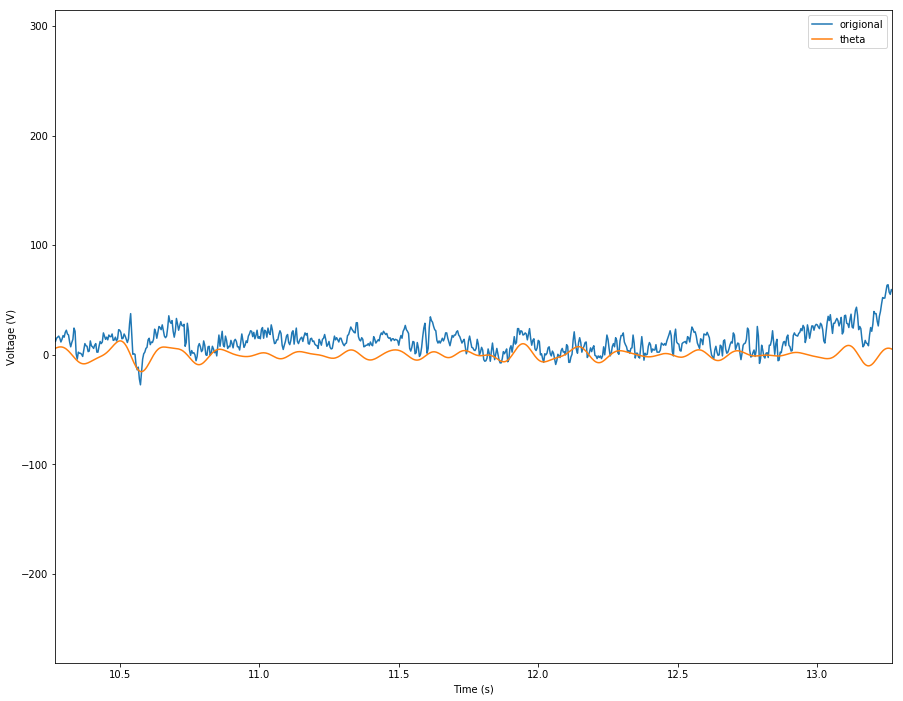

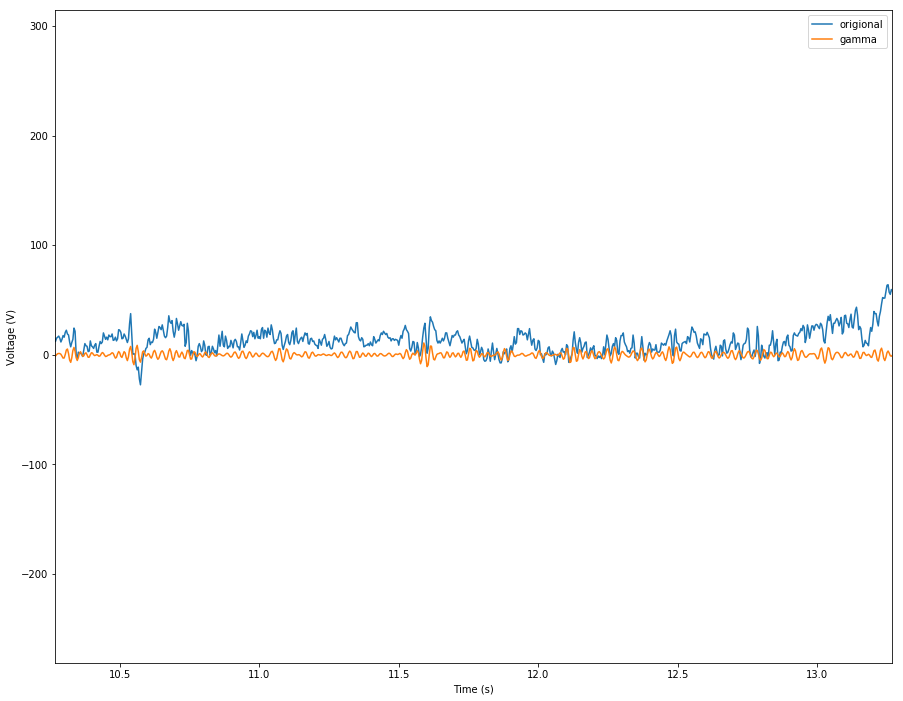

In [16]:
FIR_theta = signal.firwin(751, cutoff=(4,10), fs=fs, pass_zero=False)
theta_osc = np.empty(M1_eeg.shape)
theta_osc[0] = np.convolve(M1_eeg[0], FIR_theta, mode='same')
theta_osc[1] = np.convolve(M1_eeg[2], FIR_theta, mode='same')
theta_osc[2] = np.convolve(M1_eeg[2], FIR_theta, mode='same')
theta_osc[3] = np.convolve(M1_eeg[3], FIR_theta, mode='same')
theta_osc[4] = np.convolve(M1_eeg[4], FIR_theta, mode='same')

FIR_gamma = signal.firwin(251, cutoff=(30,50), fs=fs, pass_zero=False)
gamma_osc =  np.empty(M1_eeg.shape)
gamma_osc[0] = np.convolve(M1_eeg[0], FIR_gamma, mode='same')
gamma_osc[1] = np.convolve(M1_eeg[2], FIR_gamma, mode='same')
gamma_osc[2] = np.convolve(M1_eeg[2], FIR_gamma, mode='same')
gamma_osc[3] = np.convolve(M1_eeg[3], FIR_gamma, mode='same')
gamma_osc[4] = np.convolve(M1_eeg[4], FIR_gamma, mode='same')

t_vector = np.arange(0,len(M1_eeg[0])/fs,1/fs)

plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.plot(t_vector, F1_eeg[0], '-', label = "origional")
plt.plot(t_vector, theta_osc[0], '-', label = "theta")
plt.xlim([M1_time_vector[2885]-1,M1_time_vector[2885]+2])
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
plt.legend()

plt.figure(figsize=(15,12))
# plot the signal and the filtered signal
plt.plot(t_vector, M1_eeg[0], '-', label = "origional")
plt.plot(t_vector, gamma_osc[0], '-', label = "gamma")
plt.xlim(M1_time_vector[2885]-1,M1_time_vector[2885]+2)
plt.xlabel('Time (s)'); plt.ylabel('Voltage (V)');
plt.legend()



In [17]:
def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

In [18]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

In [19]:
def get_all_epochs(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        start = index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0
        end = index+(len_post*fs)
        baseline = np.mean(data[start:index])
        for value in data[start:end]:
            epoch.append(value - baseline)
        epoch_list.append(epoch)
    all_epochs = np.array(epoch_list)
    return all_epochs